# Importing Libraries 

In [1]:
%matplotlib notebook

import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
import random 

from pca_plotter import PCAPlotter

# Importing the data

In [2]:
# Inspecting shape of data 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


In [3]:
# Normalizing and reshaping the data 
x_train = np.reshape(x_train, (x_train.shape[0], 784)) / 255.
x_test = np.reshape(x_test, (x_test.shape[0], 784)) / 255.
print(x_train.shape)

(60000, 784)


# Plotting Examples

In [4]:
# Plotting sample of the data 
def plot_triplets(triplet):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(np.reshape(triplet[i], (28, 28)), cmap='binary')
        plt.yticks([])
        plt.xticks([])
    plt.show()

<IPython.core.display.Javascript object>


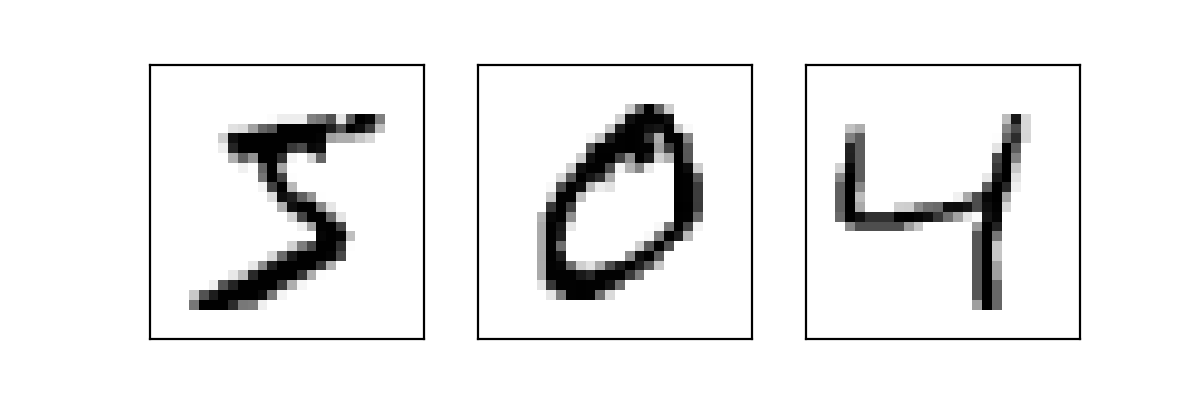

In [5]:
plot_triplets([x_train[0], x_train[1], x_train[2]])

# Batch of Triplets 

In [6]:
def create_batch(batch_size=256):
    x_anchors = np.zeros((batch_size, 784))
    x_positives = np.zeros((batch_size, 784))
    x_negatives = np.zeros((batch_size, 784))
    
    for i in range(0, batch_size):
        # Find anchor, a positive, and negative example
        random_index = random.randint(0, x_train.shape[0] - 1)
        x_anchor = x_train[random_index]
        y = y_train[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

<IPython.core.display.Javascript object>


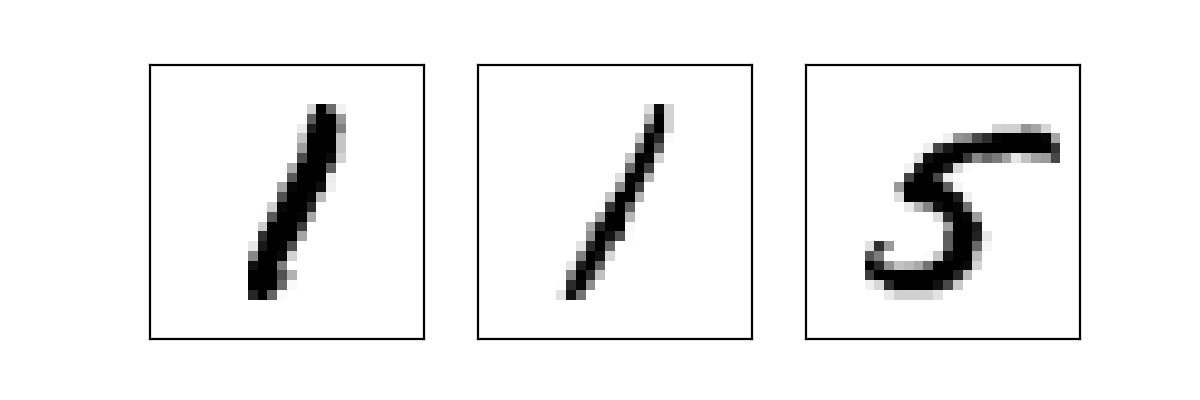

In [7]:
triplets = create_batch(1)
plot_triplets(triplets)

# Embedding Model

In [8]:
emb_size = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(emb_size, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [9]:
example = np.expand_dims(x_train[0], axis=0)
example_emb = embedding_model.predict(example)[0]

print(example_emb)

[0.49650097 0.40673918 0.49216795 0.5483363  0.33894578 0.42247027
 0.65208125 0.47605923 0.46972385 0.57271945 0.4803958  0.5272513
 0.47434554 0.4932446  0.4515563  0.5376341  0.40295494 0.4489823
 0.34214246 0.5110123  0.5091674  0.6603008  0.49055004 0.4538341
 0.45672968 0.4766501  0.64559597 0.42721784 0.4298002  0.49448106
 0.5716353  0.53608435 0.48310414 0.5753148  0.506536   0.493078
 0.5708866  0.6140322  0.5477571  0.49293122 0.6227568  0.5610144
 0.55094314 0.718722   0.48444578 0.44620284 0.44527832 0.6135884
 0.52977604 0.49616164 0.5490996  0.572083   0.6571625  0.5214774
 0.52790487 0.5121282  0.5997534  0.553828   0.5806754  0.6312605
 0.42419773 0.44715104 0.52969724 0.4622951 ]


# Siamese Network

In [10]:
input_anchor = tf.keras.layers.Input(shape=(784,))
input_positive = tf.keras.layers.Input(shape=(784,))
input_negative = tf.keras.layers.Input(shape=(784,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64)           54400       ['input_1[0][0]',                
                                                                  'input_2[0][0]',            

# Triplet Loss

In [11]:
alpha = 0.2

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

# Data Generator 

In [12]:
def data_generator(batch_size=256):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

# Model Training 

<IPython.core.display.Javascript object>


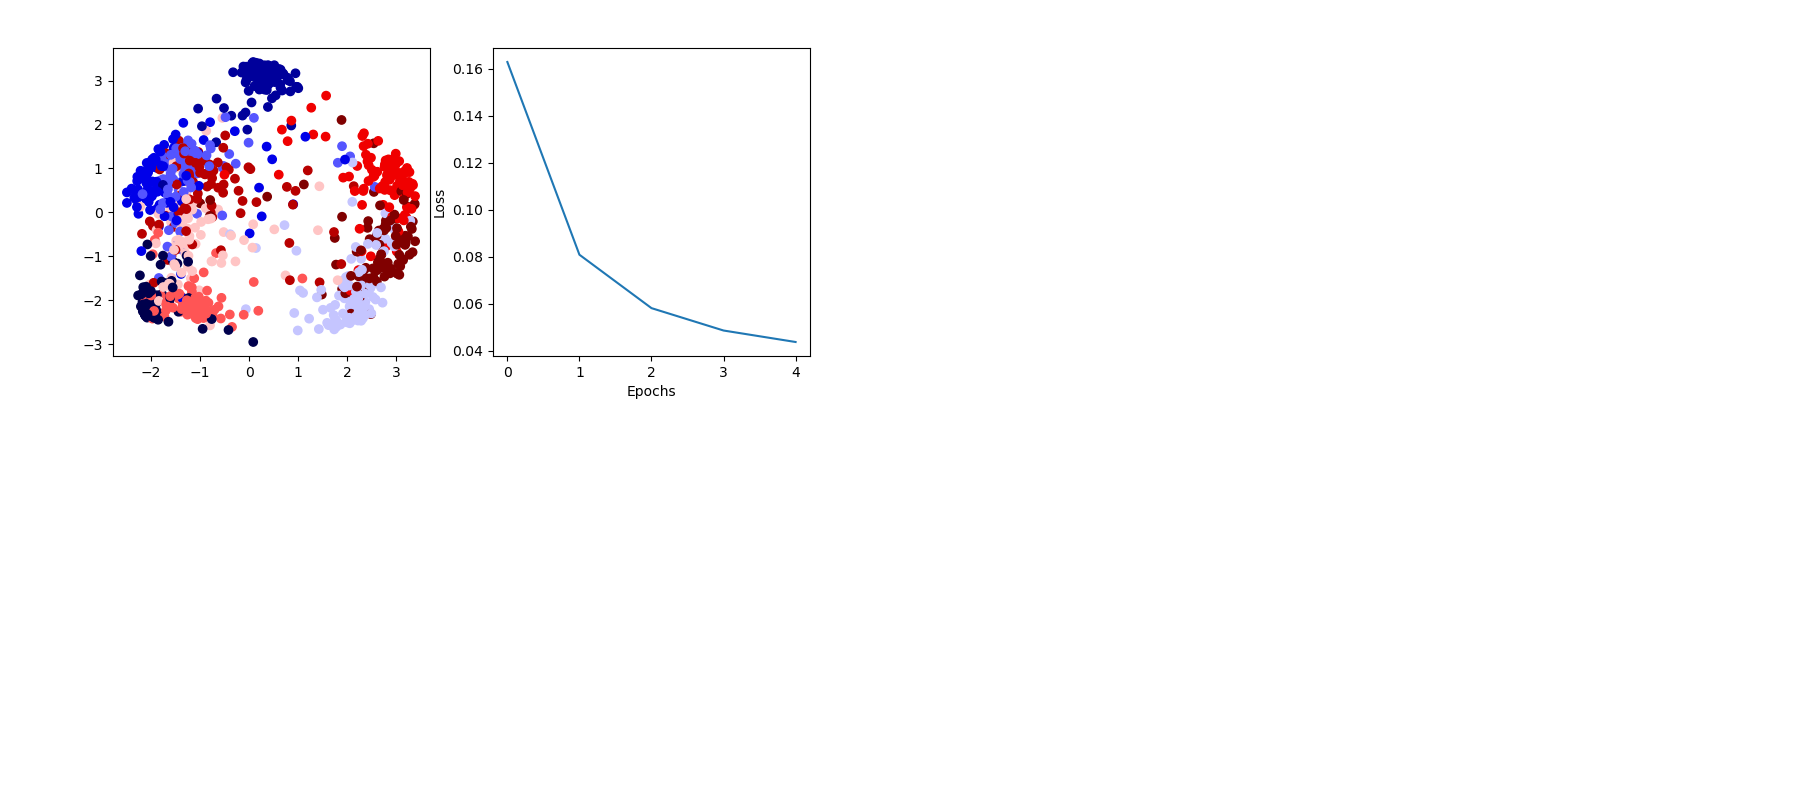

In [ ]:
batch_size = 2048
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)

net.compile(loss=triplet_loss, optimizer='adam')

_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=False,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test[:1000], y_test[:1000]
        )]
)